# 2nd Assignment on Medical Image Processing

## UE 183.630 - 2025 SoSe

---

### Assignment

Aim of the second assignment is the implementation of a segmentation algorithm for bone contours. We will investigate image features extraction and selection methods as bases for image segmentation. Three different approaches are investigated, (1) a classifier based approach using Random Forests, (2) a Deep Learning approach using a UNet and (3) a bone contour Shape Model based approach that uses PCA resulting in a simplified version of Particle Filters.

Relevant topics within this exercise:
- Feature extraction
- Classification and feature selection using Random Forests
- Implementation and optimization of a cost function for segmentation


#### Helper Functions in `helper_functions.py`

- `get_data` loads all the necessary variables that you will be working on
- `plot_shape` can be used to plot generated shapes and the given mean shape
- `plot_convolutions` plots images along with their convolutions
- `plot_prediction_triplets` plots triplets of images, segmentation predictions and segmentation ground truths
- `show_feature_importance` visualizes the importance of a Random Forest's features
- `evaluate_binary_segmentation` evaluates a binary segmentation using a Confusion Matrix, Dice Score, Precision and Recall
- `optimize` is used to optimize parameters with a given cost function `f`
- `plot_fitted_shapes` plots fitted shapes together with a segmentation and optionally with the ground truth landmarks

`train_unet_model` trains a U-Net and returns the trained model and is contained in `training.py`

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import get_data

### Load data used in this exercise

In [2]:
images, masks, landmarks, aligned = get_data()

images: list of 50 images, each as a 2D array with varying sizes
masks: list of 50 contour segmentation masks, each as a 2D array with varying sizes - corresponding to images
landmarks: list of 50 raw landmark coordinates, each as a 2D array of shape (2, n_landmarks)
aligned: np.ndarray of shape (50, 2, 64) containing aligned landmark coordinates for all samples, preprocessed for PCA


# 1. Data Exploration

### 1.1. Plot the first 5 bone images (stored in `images`) and the respective landmarks (stored in `landmarks`) on top.
- Hint: `imshow` and `scatter`

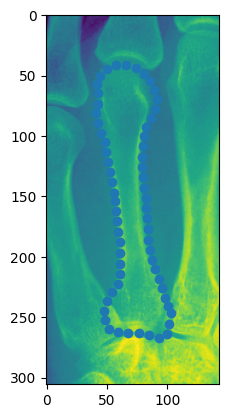

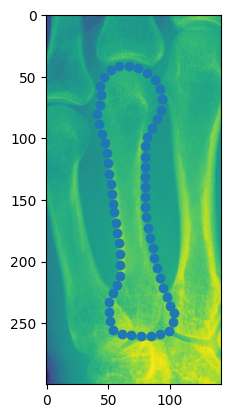

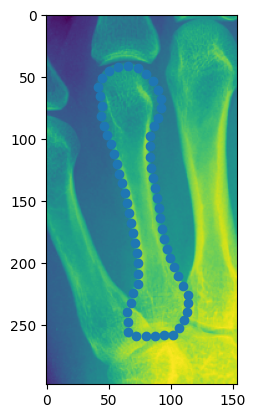

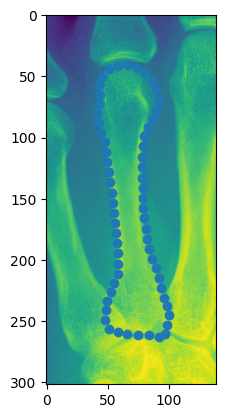

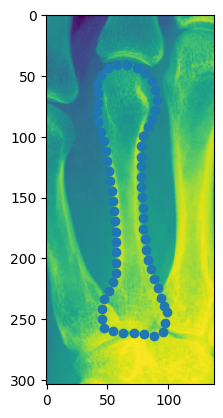

In [3]:
for i in range(5):
    plt.imshow(images[i])
    plt.scatter(landmarks[i][0, :], landmarks[i][1, :])
    plt.show()

### 1.2. Plot one set of landmarks together with the corresponding set of aligned landmarks.

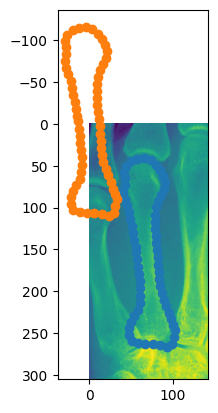

In [4]:
plt.imshow(images[0])
plt.scatter(landmarks[0][0, :], landmarks[0][1, :])
plt.scatter(aligned[0, 0, :], aligned[0, 1, :])
plt.show()

### 1.3. Extend `generate_shape` so that it allows rotation, scaling and translation of shapes according to the parameters `scaling, rotation, x_t, y_t` and test your function.

- Copy your function `generate_shape` from Assignment 1.
- Add functionality for rotation, scaling and translation (hint: rotation matrix).


In [5]:
def generate_shape(b, eigen_vectors, mean_shape, scaling, rotation, x_t, y_t):
    """
    Generate a 2D shape instance from PCA parameters and an affine transform.

    Parameters
    ----------
    b : ndarray
        PCA weight coefficients (length <= n_components).
    eigen_vectors : ndarray
        PCA principal axes with shape (2N, n_components).
    mean_shape : ndarray
        Mean-shape vector of length 2N.
    scaling : float
        Scaling factor.
    rotation : float
        Rotation angle in degrees.
    x_t : float
        Translation offset in the x-direction.
    y_t : float
        Translation offset in the y-direction.

    Returns
    -------
    new_shape : ndarray
        Transformed shape coordinates in the format [x1, ..., xN, y1, ..., yN].
    """

    # Linearly combine mean with first len(b) eigenvectors
    new_shape = mean_shape + b @ eigen_vectors[:len(b), :]

    # Scale all values by the given scalar
    new_shape *= scaling

    # Convert rotation to radians and construct rotation matrix
    rotation_rad = np.radians(rotation)
    transform = np.array([
        [np.cos(rotation_rad), -np.sin(rotation_rad)],
        [np.sin(rotation_rad), np.cos(rotation_rad)]
    ])

    # Reshape [x1, ... , xN, y1, ..., yN] to [[x1, ..., xN], [y1, ..., yN]] in order to apply out 2x2 rotation matrix to it
    new_shape = new_shape.reshape(2, -1)
    new_shape = transform @ new_shape

    # Add x and y translation to their respective rows
    new_shape += np.array([[x_t], [y_t]])

    # Flatten [[x1, ..., xN], [y1, ..., yN]] back to [x1, ... , xN, y1, ..., yN]
    return new_shape.flatten()

### 1.4. Test your adapted function `generate_shape`.

- Perform PCA on the first 30 landmark sets in `aligned` with a reasonable number of components (required data shape: (30, 128)). You may use the function `PCA` from `sklearn`.
- Use your group number assigned in TUWEL for parameterizing the following transformations:
    - rotate by **90 + 2 * [group_number] degrees**
    - translate by **90 + [group_number] pixels** in x direction and **-50 pixels** in y direction
    - scale by a factor of **1.5**
    - use a PCA weight vector of your choice
- Apply the transformation and plot the shape and the mean_shape using `plot_shape`

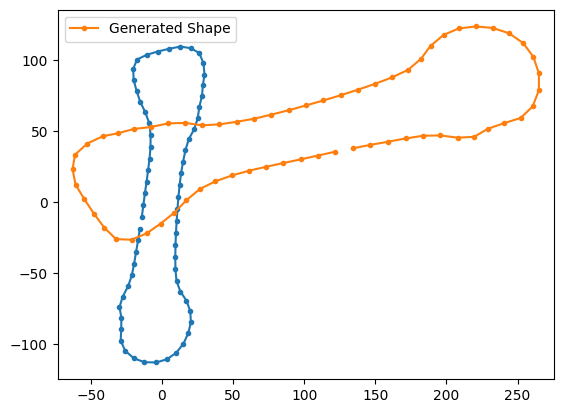

In [6]:
from helper_functions import plot_shape
from sklearn.decomposition import PCA

data = np.stack([lm.flatten() for lm in aligned[:30]])  # shape (30,128)

n_comp = None # Use all

pca = PCA(n_components=n_comp)
pca.fit(data)

# PCA weight vector (zeros uses mean shape)
b = np.zeros(pca.components_.shape[0])

# Affine transform parameters for testing
group_number = 10
scaling = 1.5
rotation = 90 + 2 * group_number
x_t, y_t = 90 + group_number, 50

mean_shape = np.mean(data, axis=0)
new_shape = generate_shape(b, pca.components_, mean_shape, scaling, rotation, x_t, y_t)

# Plot the generated and mean shapes
plot_shape(new_shape, mean_shape)

# 2. Feature Extraction and Edge Detection via Convolutions

### 2.1. Edge Detection via Convolutions
#### (a) Kernels
Create 2 edge detection kernels (image filters) represented as matrices (Fx, Fy) of dimension `[i,j]` where `i` and `j` are 3. We will focus on the filters called Prewitt Operator. These have the aim to identify edges in images by focusing on detecting changes in intensity levels. You should implement a horizontal and vertical edge detection filter. You may also create additional kernels for edge detection, if you want to experiment with these.


In [ ]:
# TODO Define PREWITT kernels for X and Y


#### (b) Convolution operation
- Implement the convolution operation on your own as function `conv2d` with input parameters `image` representing a 2D image of size [m, n] and `kernel` representing a `3x3` filter kernel.
- The output should be the convolved image of size [m,n]. For convolving the kerning at the image boundaries image padding with 0 values should be used.

In [ ]:
def conv2d(image, kernel):
    """
    Convolve a 2D image with a 3×3 kernel, preserving input size.

    Parameters
    ----------
    image : ndarray
        2D input image array.
    kernel : ndarray
        2D convolution kernel of shape (3, 3).

    Returns
    -------
    output : ndarray
        2D array of the same shape as the input image.
    """

    # TODO: Initialize output array
    output = 

    # TODO: add padding to preserve input size
    
    # TODO: Loop over the image and apply the kernel

    return output

#### (c) Test your convolution operation
- Select 3 random bone images from `images` and convolve each of them with the filters you created.
- Visualize the resuling images using `plot_convolutions`.

In [ ]:
from helper_functions import plot_convolutions

kernels = {
    'Prewitt X': PREWITT_X,
    'Prewitt Y': PREWITT_Y,
}

originals = # TODO: select 3 images
convolved = []
for i in originals:
    conv = [conv2d(i, kernel) for kernel in kernels.values()]
    convolved.append(conv)

plot_convolutions(originals, convolved, kernels)

### 2.2. Image Feature Computation
- Implement `compute_features(image)` which returns a feature matrix of size `[nfeatures, npixels]` of an image, including the following features:
    - Grey value of an image
    - Gradient in x- and y-direction (using the kernels you created)
    - Magnitude of the gradient
    - x- and y-coordinates of the pixels (hint: `np.meshgrid`)
- Feel free to implement and evaluate other additional features. You are free to use libraries such as `skimage` (e.g. from [features](https://scikit-image.org/docs/0.25.x/api/skimage.feature.html) or [filters](https://scikit-image.org/docs/0.25.x/api/skimage.filters.html)).
- Visualize the features for the first image in `images`.

Note: some features may be computationally expensive, so the results of `compute_features` can be cached. If you wish to not use this feature, you can remove the annotation (`@memory.cache`). In case you change your implementation of `compute_features`, do not forget to delete the directory `cache_dir` to clear the cache.

In [ ]:
from joblib import Memory
cache_dir = os.path.join(os.getcwd(), 'cache_dir')
memory = Memory(location=cache_dir, verbose=0)

In [ ]:
from skimage.feature import canny

@memory.cache
def compute_features(image):
    """
    Extract features from a 2D grayscale image.

    Parameters
    ----------
    image : np.ndarray
        A 2D NumPy array of shape (H, W), representing a grayscale image.

    Returns
    -------
    features : np.ndarray
        A 2D array of shape (F, N), where:
        - F is the number of extracted features,
        - N is the number of pixels (H × W).
    """

    
    H, W = image.shape

    # TODO: get the grayscale values

    # TODO: get convolution results for X and Y
    edge_x = 
    edge_y = 

    # TODO: get the magnitude values of the convolution results
    gmag_x =
    gmag_y = 

    # TODO: get X and Y coordinates of the pixels
    x_coords =
    y_coords = 

    # OPTIONAL TODO: add additional features (e.g.: canny, sobel)

    features = np.vstack([
        grey,
        edge_x, edge_y,
        gmag_x, gmag_y,
        x_coords, y_coords,
    ])

    return features

#### Visualize Features

In [ ]:
test_image = images[0]
H, W = test_image.shape
features_test = compute_features(test_image)

# TODO: get titles and features for plotting
titles = []
feats = []

fig, axes = plt.subplots(, figsize=(8, 8))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    if idx < len(feats):
        ax.imshow(feats[idx], cmap='gray', vmin=0, vmax=np.percentile(feats[idx], 99))
        ax.set_title(titles[idx])
    ax.axis('off')

plt.tight_layout()
plt.show()

# 3. Classification and Feature Selection
In this task we investigate how image features are selected to train a classifier to solve a binary classification task - the detection of edges (bone contours) in an image.

The classification result provides per image pixel a label, where 1 denotes an edge  and 0 background/no edge. In total in this tasks we will compare and explore three bone contour extraction methods: (1) Random Forest, (2) a U-Net based Deep Learning framework and (3) Particle Filters using a defined training and testing set.


### 3.1. Data Preparation
- Split the image set of 50 images and the corresponding masks into a training set of 30 images (`I_train`) and masks (`y_train`) and a test set of 20 images (`I_test`) and corresponding masks (`y_test`).
- Compute the features of all images and store them in `X_train` and `X_test`, respectively.

In [ ]:
I_train = 
y_train =
I_test = 
y_test = 

### 3.2. Random Forest (RF)
- Implement the function `train_rf` which takes a list of feature arrays and labels (masks) and trains a Random Forest classifier and returns the trained classifier.
- Implement the function `predict_segmentation_rf` which takes a trained Random Forest classifier and an image and returns a predicted segmentation.

#### (a) Define a Random Forest Classifier
- Use the `RandomForestClassifier` from `sklearn`.
- Get familiar with the parameters and select suitable ones for training.
- The RF classifier should be trained on extracted image features and not the images directly. Thus, compute image features for all input images in `I_train` and `I_test` and store the resulting features in `X_train` and `X_test`.
- **Hint**: to speed up the training process you should use all pixels of the bone contours but only a randomly sampled subset of the background pixels (equal amount of fore- (bone contours) and background (non-bone contours)).

In [ ]:
X_train = 
X_test = 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def train_rf(features, labels, n_trees=100, random_state=0):
    """
    Train a Random Forest classifier with class balancing via undersampling.

    This function concatenates feature and label arrays, balances the classes
    by undersampling the majority class (negative class), and trains a
    Random Forest classifier.

    Parameters
    ----------
    features : list of np.ndarray
        List of feature arrays to be horizontally stacked. Each array should
        have shape (F, N), where F is the number of features and N is the number of samples.
    labels : list of np.ndarray
        List of label arrays (same shape as image masks). Non-zero values are treated as positive class.
    n_trees : int, optional
        Number of trees in the Random Forest (default is 100).
    random_state : int, optional
        Seed for reproducibility (default is 0).

    Returns
    -------
    clf : RandomForestClassifier
        Trained Random Forest classifier with out-of-bag (OOB) score enabled.
    """

    # TODO get features and labels and train RandomForestClassifier

    return clf

#### (b) Train the classifier
- Use the image features  `X_train` as input to train a Random Forest classifier and the corresponding image masks `y_train` as class labels.

In [ ]:
rf_clf = # TODO: train Random Forest classifier

#### (c) Predict segmentations
- Implement the function `predict_segmentation_rf` which takes the Random Forest classifier as well as an image and returns the prediction from the classifier.
- Visualize the prediction of the first test image (from `I_test`) and compare it to the corresponding target label from `y_test`.

In [ ]:
def predict_segmentation_rf(clf, image):
    '''
    clf: Trained Random Forest classifier
    image: 2D grayscale image for segmentation prediction

    returns:
    segmentation: 2D array with predicted segmentation mask
    '''
    
    # TODO Predict segmentation using the trained Random Forest classifier

    return segmentation

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6))

# TODO: visualize the predicted segmentation and the ground truth mask

#### (d) Predict all bone contours
- Use the trained classifier and predict bone contours for the feature test set `X_test` and store the predictions in `y_pred_RF`.
- Compare the bone contour predictions to the target labels `y_test` using the helper function `evaluate_binary_segmentation` to get Dice Score, Precision and Recall. What do these scores mean and what are they saying about the model's performance?
- Qualitatively compare the images to the bone contour predictions and the ground truth using `plot_prediction_triplets`.
- Evaluate and interpret the importance of different features using `show_feature_importance`. Make sure to pass the feature labels in the same order that you used to train the classifier.
- Where is the model struggling? Where is it performing well?
- Alternate the input features and compare the results - leave features in the training out and discuss the feature importance of the Random Forest classifier features.

In [ ]:
y_pred_RF = # TODO: predict_segmentation_rf(rf_clf, I_test[0])

In [ ]:
from helper_functions import plot_prediction_triplets, show_feature_importance, evaluate_binary_segmentation

In [ ]:
results = evaluate_binary_segmentation(y_pred_RF, y_test)
print("Dice Score:", results['dice'])
print("Precision:", results['precision'])
print("Recall:", results['recall'])

In [ ]:
plot_prediction_triplets(I_test, y_pred_RF, y_test)

In [ ]:
show_feature_importance(rf_clf, titles)

### 3.3. U-Net
In this task you will compare your results from the Random Forest segmentation to those from a U-Net. You will train two networks – one with data augmentation and one without. Feel free to tweak any hyperparameters if needed.
Then, you will evaluate the results and compare them to the Random Forest.

(Network details: the given convolutional neural network (CNN) is a U-Net ([paper](https://arxiv.org/pdf/1505.04597)) combined with a ResNet-34 backbone ([paper](https://arxiv.org/pdf/1512.03385)). It is lightweight and should be able to run about 100 epochs in less than 10 minutes even when only using a CPU. Unlike a regular ResNet, the residual connections are made on upsampling, where regular U-Nets would have concatenations. The `train_unet_model` function takes in all images and masks and splits them 30-10-10 into training, validation and testing. The model with the smallest validation loss will be returned. Note that every time the model has a new "best model", it saves the checkpoint in the `checkpoints` directory. These checkpoints are not deleted automatically and may start to take up considerable storage space when training multiple times.)

#### (a) Train two networks
 Train the networks `y_pred_UNet1` and `y_pred_UNet2`. The code is already given and when run, `train_unet_model` will plot training and validation loss after training. Compare the visualized loss-graphs with each other and discuss these. What is affecting them? Why are they different?

If you want, you can tweak the learning rate and the number of epochs for training using the parameters `lr` and `n_epochs`. Should you have troubles with a cuda device or mps, simply use the `device_override` parameter to use a different device, e.g. `device_override='cpu'`.

In [ ]:
from training import train_unet_model

In [ ]:
y_pred_UNet1 = train_unet_model(images, masks, augment=False, lr=1e-4)

In [ ]:
y_pred_UNet2 = train_unet_model(images, masks, augment=True, lr=1e-4)

#### (b) Interpret filters
Instead of using a predefined set of filters (as we used in Task 2.1 for edge detection),  a convolutional neural network – learns the filter weights  during training to extract image features in combination with convolution. In this task we want to analyse and visualize which image features are extracted by the first layer of one of the trained U-Net classifiers. Therefore, use the trained U-Net model's method `show_first_layer_outputs` and a test image of your choice.
Interpret what image features the learned filters are extracting  (e.g. are these focusing on detecting  edges or shapes.)

In [ ]:
y_pred_UNet2.show_first_layer_outputs(images[0])

#### (c) Predict contours
- Use the trained U-Net classifiers to predict the bone contours for the image test set `I_test` and store the predictions in `y_pred_UNet1` and `y_pred_UNet2`.
- Compare the bone contour predictions `y_pred_UNet[1,2]` to the target labels `y_test` the same way you did for the Random Forest.
- Evaluate and interpret the impact of (not) using data augmentation in the training process qualitatively (visualizations – you may use `plot_prediction_triplets`) and quantitatively (similarity metrics) for the test set.

In [ ]:
y_pred_UNet1 = # TODO: predict segmentation for y_pred_UNet1 on I_test
y_pred_UNet2 = # TODO: predict segmentation for y_pred_UNet2 on I_test

In [ ]:
plot_prediction_triplets(I_test, y_pred_UNet2, y_test)

In [ ]:
results_no_aug = evaluate_binary_segmentation(y_pred_UNet1, y_test)
print("Dice Score:", results_no_aug['dice'])
print("Precision:", results_no_aug['precision'])
print("Recall:", results_no_aug['recall'])

In [ ]:
results_with_aug = evaluate_binary_segmentation(y_pred_UNet2, y_test)
print("Dice Score:", results_with_aug['dice'])
print("Precision:", results_with_aug['precision'])
print("Recall:", results_with_aug['recall'])

#### (d) Compare to Random Forest
- Compare the performance of the U-Net to the Random Forest using the same training and testing data split for each method.
- Which method performs better?
- Are there advantages or disadvantages?
- Discuss it qualitatively and quantitatively and accurately describe the experimental setup, in such a way it is reproducible.
- Hint: you can use again the helper functions `plot_prediction_triplets` and `evaluate_binary_segmentation`.

In [ ]:
from helper_functions import optimize

### 3.4. Shape Particle Filters (PF)
Shape particle filters are sequential Monte Carlo Methods used for solving a segmentation task. Therefore a shape model is required, which subsequently is fitted to the image to be segmented. For this task we will be using the PCA shape model of the first 30 images (created in Task 1.4 of this assignment) and create a fitting routine including the definition of a cost function used in the optimization process of the fitting. The shape model will be fitted to the output of the Random Forest segmentations.

#### (a) Implement `fit_shape_model` and `cost_function`
As the first step we formulate a function that models costs of fitting a shape to a target image. We are looking for a point in a parameter space (described by shape parameters, rotation, scaling, and translation) which describes an optimal fitted shape that segments the contours of a target object.
Implement the function `fit_shape_model` which should take a target image segmentation (in our case a predicted segmentation by the RF classifier in `y_pred_RF`) and the parameters _p_ of the shape model as input. The implemented function should fit the shape model to the  target segmentation.
- For running the optimization, use the helper function `optimize`, which takes a cost function (`cost_function`) and the upper and lower boundaries for the parameters to optimize.
- Implement the cost function which returns a scalar value that describes how well the (from _p_) generated shapes fits the classification result. (The better the shape fits the classification result, the lower the returned value). Describe the implemented cost function in your report. The cost function will be used by `fit_shape_model` in order to run the optimization for fitting the shape model to the segmentation.

Both `fit_shape_model` and `cost_function` will use `generate_shape` to generate shapes based on the shape parameters of the shape model and the transformation parameters used for scaling, rotation and translation.

In [ ]:
from scipy.ndimage import distance_transform_edt as edt

def cost_function(p, classification, eigen_vectors, mean_data):
    """
    Cost function between PCA-generated shape and a classification.

    Parameters
    ----------
    p : array_like
        Shape + transform parameters [b..., scale, rotation, x_t, y_t]
    classification : ndarray, shape (H, W)
        Segmentation mask (values in [0, 1])
    eigen_vectors : ndarray, shape (2N, d)
        PCA shape eigenvectors
    mean_data : ndarray, shape (2N,)
        Mean shape (flattened)

    Returns
    -------
    cost : float
        Fitting cost.
    """

    # TODO: get b, scale, rot, x_t, y_t from p and generate a shape using them

    # TODO: calculate cost of fitting shape
   
    return cost

In [ ]:
def fit_shape_model(segmentation, eigen_vectors, eigen_values, mean_shape):
    """
    Fit a PCA-based shape model to a binary segmentation mask using global optimization.

    Parameters
    ----------
    segmentation : np.ndarray
        Binary segmentation mask (2D array with shape H×W).
    eigen_vectors : np.ndarray
        Matrix of eigenvectors from PCA, shape (2N, d), where N is number of shape points.
    eigen_values : np.ndarray
        1D array of eigenvalues from PCA, shape (d,).
    mean_shape : np.ndarray
        Mean shape vector, shape (2N,).

    Returns
    -------
    fitted_shape : np.ndarray
        Optimized shape vector in pixel coordinates, shape (2N,).
    best_params : np.ndarray
        Optimal parameters [b_opt, scale, rotation_deg, x_translation, y_translation], shape (d + 4,).
    """

    # TODO: Define bounds for optimization
    b_lower = 
    b_upper = 
    scale_lower, scale_upper = 
    rot_lower,   rot_upper   =
    x_lower, x_upper = 
    y_lower, y_upper = 

    # TODO: concatenate the bounds for b, scale, rotation, x, and y into min_ and max_
    min_ = 
    max_ = 
    assert min_.shape == max_.shape == (d + 4,)

    def unified_cost_fn(p):
        return cost_function(p, segmentation, eigen_vectors, mean_shape)

    # optimize
    best_params = optimize(unified_cost_fn, min_, max_, random_state=0)

    # unpack optimal parameters
    b_opt      = best_params[:d]
    scale_opt  = best_params[d]
    rot_opt    = best_params[d + 1]
    x_t_opt    = best_params[d + 2]
    y_t_opt    = best_params[d + 3]

    # Reconstruct the final shape in image coordinates
    fitted_shape = generate_shape(
        b_opt,
        eigen_vectors,
        mean_shape,
        scale_opt,
        rot_opt,
        x_t_opt,
        y_t_opt
    )

    return fitted_shape, best_params

#### (b) Optimize for all test segmentations
- Optimize this function for all segmentations in `y_pred_RF` (20). We are using a stochastic optimization approach called Differential Evolution for this purpose.
- This method is very simple, robust and converges fast. We provide an implementation of this approach in optimize. An example to create and use a cost function for an optimization process can be found in `optimize_demo.py`. You can simply run it to get an example demonstration of the optimization.
- Visualize your results using the helper function plot_fitted_shapes. You may also plot the ground truth landmarks using this function.
- Describe the results. Where is the optimization struggling? What could be the underlying issue?

In [ ]:
from helper_functions import plot_fitted_shapes

In [ ]:
fitted_shapes = #TODO: get fitted shapes for each segmentation in y_pred_RF

In [ ]:
plot_fitted_shapes(fitted_shapes, y_pred_RF, gt_landmarks=landmarks[30:])